In [1]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [2]:
###### Espace latent 2 dimensions

latent_dims = 64
num_epochs = 500
batch_size = 25
capacity = 2
learning_rate = 5e-4
variational_beta = 0.00001
# use_gpu = True



# # 10-d Espace latent en 10 dimensions, qui correspond à un Autoencoder simple (à comparer avec le VAE 
# et un espace latent de 2 dimensions)
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

# Chargement des données 


In [3]:
import os
import descriptors
import numpy as np

dict_r = np.load('data_dict.npy', allow_pickle=True).item()

train_db = np.zeros([len(dict_r['env']),2,750])


i = 0
for sample in dict_r['env']:
    train_db[i,:,:] = sample
    i+=1
    
MAX1 = np.max(train_db[:,0,:])
MAX2 = np.max(train_db[:,1,:])
train_db[:,0,:] /= MAX1
train_db[:,1,:] /= MAX2
train_dataset =  torch.utils.data.TensorDataset(torch.from_numpy(train_db))

print(train_db.shape)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)

test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)

(252, 2, 750)


# Defintion du VAE 

Kernel Size = 4 papier qui explique pourquoi: https://distill.pub/2016/deconv-checkerboard/

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
#         self.conv1 = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=c, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(c))
#         self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(2*c)) 
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=2, out_channels=c, kernel_size=20, stride=2, padding=7), nn.BatchNorm1d(c)) # out: c, 372
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=c, out_channels=c*2, kernel_size=20, stride=2, padding=7), nn.BatchNorm1d(2*c)) # out: c*2, 186
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=c*2, out_channels=c*4, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(4*c)) # out: c*2, 186
        self.conv4 = nn.Sequential(nn.Conv1d(in_channels=c*4, out_channels=c*8, kernel_size=5, stride=2, padding=2), nn.BatchNorm1d(8*c)) # out: c*2, 186
        self.lin1 = nn.Linear(8*c*46, latent_dims*4)
        self.fc_mu = nn.Linear(in_features=latent_dims*4, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=latent_dims*4, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.lin1(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=latent_dims*4)
#         self.conv2 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(c))
#         self.conv1 = nn.Sequential(nn.ConvTranspose1d(in_channels=c, out_channels=1, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(1))
        self.lin1 = nn.Linear(latent_dims*4, 8*c*46)
        self.conv4 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*8, out_channels=c*4, kernel_size=5, stride=2, padding=2, output_padding=1), nn.BatchNorm1d(c*4))
        self.conv3 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*4, out_channels=c*2, kernel_size=5, stride=2, padding=2, output_padding=1), nn.BatchNorm1d(c*2))
        self.conv2 = nn.Sequential(nn.ConvTranspose1d(in_channels=c*2, out_channels=c, kernel_size=20, stride=2, padding=7, output_padding=1), nn.BatchNorm1d(c))
        self.conv1 = nn.Sequential(nn.ConvTranspose1d(in_channels=c, out_channels=2, kernel_size=20, stride=2, padding=7, output_padding=0), nn.BatchNorm1d(2))
            
    def forward(self, x):
        x = self.fc(x)
        x = F.relu(self.lin1(x))
        x = x.view(x.size(0), capacity*8, 46) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())/np.size(batch_size)
    
    return recon_loss + variational_beta * kldivergence, recon_loss, variational_beta * kldivergence
    
    
vae = VariationalAutoencoder()

# device = torch.device("cuda:0")
# vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 429578


# Entrainement

In [5]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []
train_loss_avg2 = []
train_loss_avg3 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    train_loss_avg2.append(0)
    train_loss_avg3.append(0)
    num_batches = 0
    
    for image_batch in train_loader:

        #image_batch = image_batch.to(device)
        image_batch = torch.DoubleTensor(image_batch[0])
        image_batch = image_batch.view(batch_size,2,750)
        
        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch.float())
        
        # reconstruction error
        loss, loss2, loss3 = vae_loss(image_batch_recon, image_batch.float(), latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        train_loss_avg2[-1] += loss2.item()
        train_loss_avg3[-1] += loss3.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    train_loss_avg2[-1] /= num_batches
    train_loss_avg3[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f (l2 = %f, l3 = %f)' % (epoch+1, num_epochs, train_loss_avg[-1], train_loss_avg2[-1], train_loss_avg3[-1]))

Training ...


C:\Users\gabri\Anaconda3\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch [1 / 500] average reconstruction error: 0.088702 (l2 = 0.088361, l3 = 0.000341)
Epoch [2 / 500] average reconstruction error: 0.075911 (l2 = 0.074044, l3 = 0.001867)
Epoch [3 / 500] average reconstruction error: 0.057595 (l2 = 0.054258, l3 = 0.003337)
Epoch [4 / 500] average reconstruction error: 0.047603 (l2 = 0.045133, l3 = 0.002470)
Epoch [5 / 500] average reconstruction error: 0.042321 (l2 = 0.040576, l3 = 0.001745)
Epoch [6 / 500] average reconstruction error: 0.039728 (l2 = 0.038181, l3 = 0.001546)
Epoch [7 / 500] average reconstruction error: 0.036262 (l2 = 0.035008, l3 = 0.001254)
Epoch [8 / 500] average reconstruction error: 0.035199 (l2 = 0.033757, l3 = 0.001442)
Epoch [9 / 500] average reconstruction error: 0.033626 (l2 = 0.032465, l3 = 0.001162)
Epoch [10 / 500] average reconstruction error: 0.032328 (l2 = 0.030609, l3 = 0.001719)
Epoch [11 / 500] average reconstruction error: 0.030814 (l2 = 0.029268, l3 = 0.001546)
Epoch [12 / 500] average reconstruction error: 0.031

# Affichage de la courbe de loss 

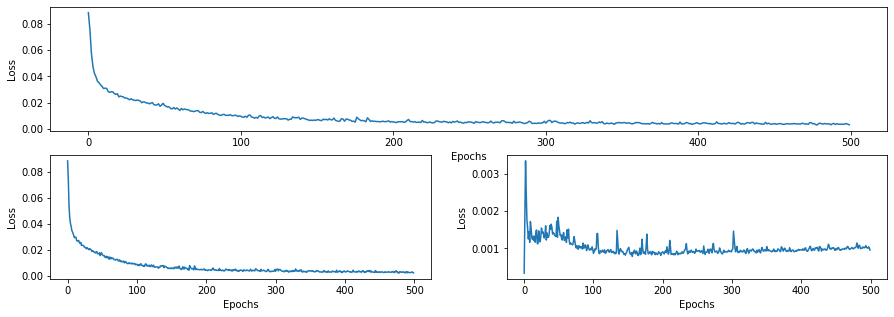

In [6]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(223)
plt.plot(train_loss_avg2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(224)
plt.plot(train_loss_avg3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Reconstruction 

data_2\Vn-ord-ff-1c-_A#6.wav
Image originale


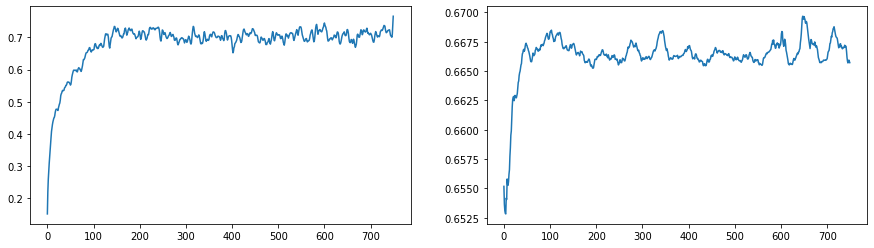

VAE reconstruction:


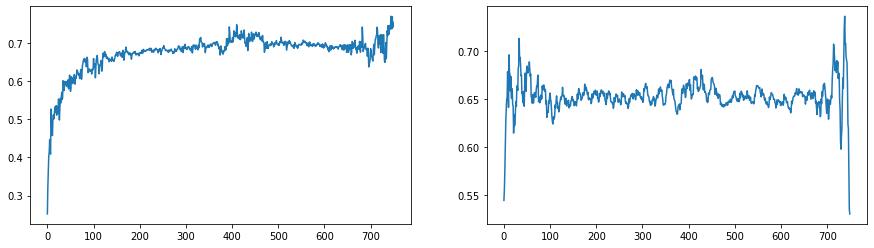

data_2\Vn-ord-ff-1c-_A#6.wav
Image originale


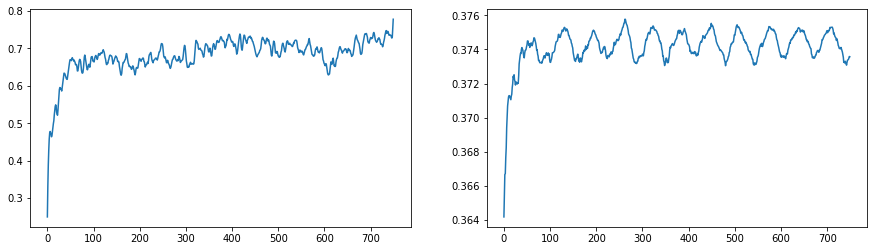

VAE reconstruction:


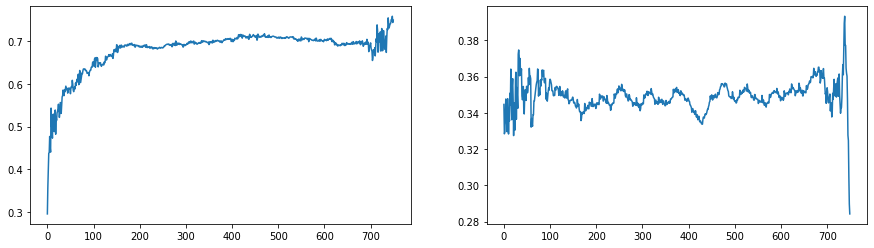

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# En entrée, l'image à reconstruire et le modèle utilisé pour la reconstruction

for i in [119,184]:
    images = train_db[i,:,:]
    # Affichage de l'image originale
    print(dict_r['file_name'][15])
    print('Image originale')

    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot((images[0,:]))
    plt.subplot(1,2,2)
    plt.plot((images[1,:]))        
    plt.show()

    # Reconstruct and visualise the images using the vae
    print('VAE reconstruction:')
    images_recon,a,b = vae(torch.from_numpy(images).view(1,2,750).float())
    images_recon = images_recon.detach().numpy()
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.plot((images_recon[0,0,:]))
    plt.subplot(1,2,2)
    plt.plot((images_recon[0,1,:])) 
    plt.show()



In [10]:
#DDSP sur la reconstruction
pitch = torch.from_numpy(images_recon[0,0,:]*MAX2).float().reshape(1, -1, 1)
loudness = torch.from_numpy(images_recon[0,1,:]*MAX1).float().reshape(1, -1, 1)

ddsp = torch.jit.load('ddsp_solordinario_pretrained.ts')

reconstruction_out = ddsp(pitch, loudness)

In [9]:
#DDSP sur l'original Original
pitch = torch.from_numpy(images[0,:]*MAX2).float().reshape(1, -1, 1)
loudness = torch.from_numpy(images[1,:]*MAX1).float().reshape(1, -1, 1)

ddsp = torch.jit.load('ddsp_solordinario_pretrained.ts')

reconstruction_in = ddsp(pitch, loudness)

In [10]:
#Ecouter les sons
import sounddevice as sd
sig = reconstruction_in[0,:,0]
sig = sig.detach().numpy()
sd.play(sig*0.5/np.max(sig), 16000)


NameError: name 'reconstruction' is not defined

AttributeError: 'AxesImage' object has no property 'nfft'

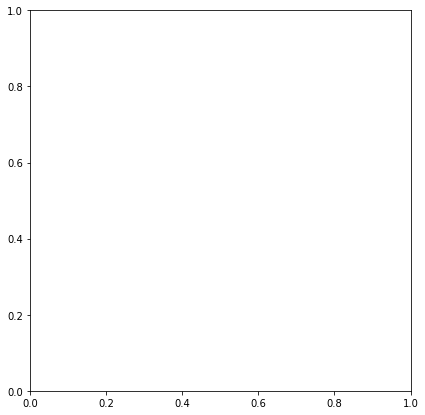

In [11]:
#Visualtisation spéctrogramme
Nfft = 256
Fs = 250


plt.figure(figsize=(15,8))
plt.subplot(121)
plt.specgram(reconstruction_in[0,:,0].detach().detach(), Nfft=Nfft, Fs=Fs, noverlap=Nfft/2)

In [12]:
#Sauvergarder valeurs de l'entrainement
torch.save(vae.state_dict(), 'Train_VAEconv_solordinario_V2')

In [7]:
#charger les valeurs
vae.load_state_dict(torch.load('Train_VAEconv_solordinario_V2'))
vae.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc_mu): Linear(in_features=192000, out_features=2, bias=True)
    (fc_logvar): Linear(in_features=192000, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=192000, bias=True)
    (conv2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

24000

In [15]:
np.min(train_db)

0.02345124901222465

torch.Tensor

'data_2\\Vn-ord-ff-1c-E7.wav'